In [6]:
import pysrt
from loguru import logger
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from collections import Counter

from pathlib import Path
from src.data import DATA_DIR

In [27]:
class Subtitle:
    def __init__(self, file_path):
        self.subtitle = pysrt.open(file_path)
        self.words = []

    def tokenize(self):
        logger.info('Tokenizing subtitle...')
        for sub in tqdm(self.subtitle):
            self.words.extend(word_tokenize(sub.text))    

In [28]:
file_path = Path('__file__').resolve().parent

In [29]:
file_path = DATA_DIR /'Game of Thrones _Winter is Coming_en.srt'

In [24]:
obj = Subtitle(file_path)
obj.tokenize()
print(Counter(obj.words).most_common(10))

2023-04-12 10:13:45.886 | INFO     | __main__:tokenize:7 - Tokenizing subtitle...
100%|█████████████████████████████████████| 2082/2082 [00:00<00:00, 2524.55it/s]


[('.', 2217), ('I', 685), (',', 621), ('you', 479), ('-', 430), ('to', 337), ('a', 324), ('the', 300), ('?', 293), ("'s", 255)]


In [32]:
Counter(obj.words).most_common(10)[0][0]

'.'

# Word_Difficulty Prediction - Kaggel

In [7]:
import os

import pandas as pd
import numpy as np
import urllib

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [45]:
sns.set_style("darkgrid")

In [25]:
df = pd.read_csv(DATA_DIR /'worddifficulty.csv')

In [9]:
df.head(3)

,Word,Length,Freq_HAL,Log_Freq_HAL,I_Mean_RT,I_Zscore,I_SD,Obs,I_Mean_Accuracy
0,a,1,10610626,16.18,798.92,-0.01,333.85,24.0,0.73
1,aah,3,222,5.40,816.43,0.21,186.03,21.0,0.62
2,Aaron,5,10806,9.29,736.06,-0.11,289.01,32.0,0.97


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40481 entries, 0 to 40480
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Word             40480 non-null  object 
 1   Length           40481 non-null  int64  
 2   Freq_HAL         40481 non-null  int64  
 3   Log_Freq_HAL     40481 non-null  float64
 4   I_Mean_RT        40468 non-null  float64
 5   I_Zscore         40468 non-null  float64
 6   I_SD             40450 non-null  float64
 7   Obs              40468 non-null  float64
 8   I_Mean_Accuracy  40481 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 2.8+ MB


In [11]:
df.isna().sum()

Word                1
Length              0
Freq_HAL            0
Log_Freq_HAL        0
I_Mean_RT          13
I_Zscore           13
I_SD               31
Obs                13
I_Mean_Accuracy     0
dtype: int64

In [12]:
df.dropna(inplace=True)

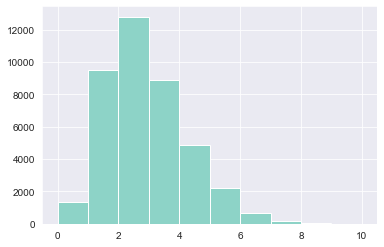

In [46]:
df['I_Zscore'].hist();

In [26]:
scaler = MinMaxScaler()

In [27]:
df['I_Zscore'] = scaler.fit_transform(df['I_Zscore'].values.reshape(-1, 1))

<AxesSubplot:>

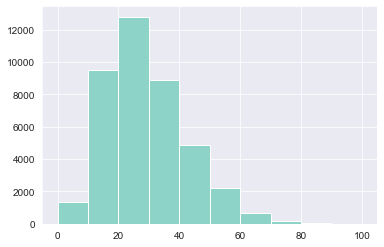

In [47]:
df['I_Zscore'] = df['I_Zscore'] *10
df['I_Zscore'].hist()

# Word Cloud Visualization

In [38]:
text = ' '.join(df['Word'].sample(np.round(df.shape[0]//2)))

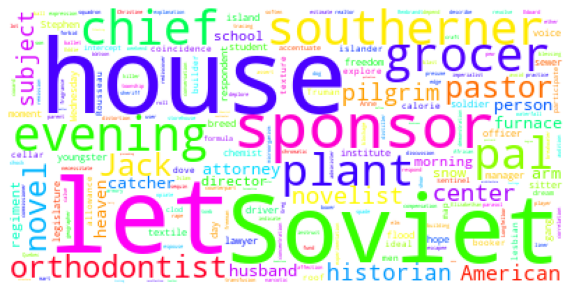

In [48]:
wordcloud = WordCloud(
    background_color="white", 
    min_font_size=0.01,
    colormap='gist_rainbow_r')
    
wordcloud.generate(text)



plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [67]:
df_hardest = df.sort_values('I_Zscore', ascending=False)
text_hardest = ' '.join(df_hardest['Word'][:10].values)

In [68]:
df_easiest = df.sort_values('I_Zscore', ascending=True)
text_easiest = ' '.join(df_easiest['Word'][:10].values)

In [71]:
print('The hardest words are: ',text_hardest,'\n')
print('The easiest words are: ',text_easiest,'\n')

The hardest words are:  diacritical pupated Mauritania semiquantitative photocathode ginner's limekiln unthematic sanest somnambulate 

The easiest words are:  filmdom house man high play job hope sea time see 



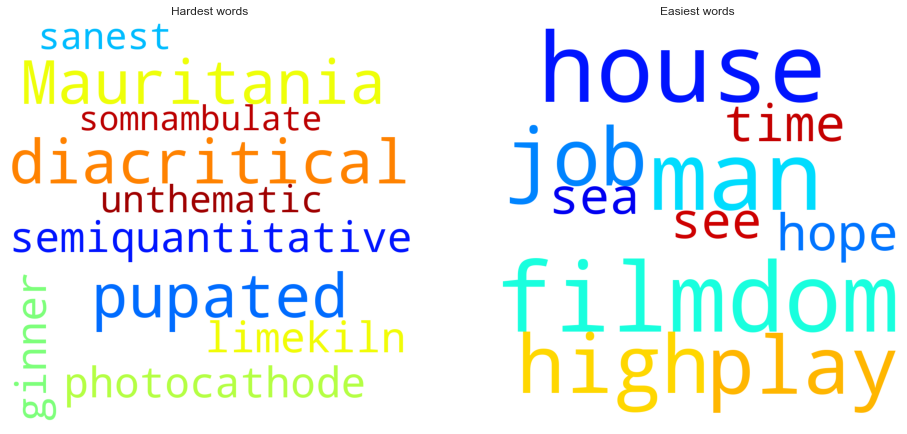

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))

wordcloud = WordCloud(
        background_color="white", 
        min_font_size=4,
        colormap='jet',
        height=1000,
        width=1000
        )
    
wordcloud.generate(text_hardest)

ax1.imshow(wordcloud)
ax1.axis("off")
ax1.set_title('Hardest words')

wordcloud.generate(text_easiest)

ax2.imshow(wordcloud)
ax2.axis("off")
ax2.set_title('Easiest words')

plt.show()


# Correlations

<AxesSubplot:>

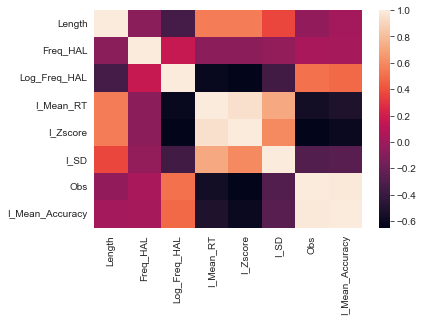

In [76]:
sns.heatmap(df.corr())

In [79]:
from itertools import tee, islice, chain

def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

In [82]:
list(previous_and_next(['a', 'z', 't', 'm']))

[(None, 'a', 'z'), ('a', 'z', 't'), ('z', 't', 'm'), ('t', 'm', None)]

In [86]:
class BidirectionalIterator(object):
    def __init__(self, collection):
        self.collection = collection
        self.index = 0

    def next(self):
        try:
            result = self.collection[self.index]
            self.index += 1
        except IndexError:
            raise StopIteration
        return result

    def prev(self):
        self.index -= 1
        if self.index < 0:
            raise StopIteration
        return self.collection[self.index]

    def __iter__(self):
        return self

In [88]:
obj = BidirectionalIterator(['a', 'z', 't', 'm'])

In [96]:
obj.prev()

'a'